In [1]:
# Package installations to work on WIRE

! pip install mamba
! mamba install gensim openai -y
! mamba install -c anaconda nltk -y
! mamba install -c conda-forge spacy -y
! mamba install -c conda-forge pyldavis -y
! mamba install -c conda-forge pypdf2 -y
! pip install transformers sentence-transformers
! pip install scikit-network
! pip install git+https://github.com/rwalk/gsdmm.git

! python -m spacy download en_core_web_sm


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (1.3.1) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['gensim', 'openai']

conda-forge/linux-64                                        Using cache
conda-

In [2]:
# imports

import csv
import json
import os
import re
from pprint import pprint
import time
import re
import unicodedata
import openai
import os
import sys
from contextlib import contextmanager
from copy import deepcopy
import string
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import SpectralEmbedding
import pickle
import sknetwork as skn

import matplotlib.pyplot as plt
import seaborn as sns


import numpy as np
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim_models
import PyPDF2

import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess

import nltk
nltk.download(["names", "stopwords", "state_union", "twitter_samples", "movie_reviews", "averaged_perceptron_tagger", "vader_lexicon", "punkt", "wordnet"])
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words("english")
from nltk.sentiment.vader import SentimentIntensityAnalyzer
ps = nltk.porter.PorterStemmer()

from gsdmm import MovieGroupProcess

from sentence_transformers import SentenceTransformer

import spacy
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

from itertools import combinations

# set seed for reproducibility
# np.random.seed(493)

[nltk_data] Downloading package names to /home/jovyan/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package state_union to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package state_union is already up-to-date!
[nltk_data] Downloading package twitter_samples to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Packag

## Functions for Text Cleaning and Topic Modeling (Same as before)

In [3]:
def tokeniz(sentences):
    for sentence in sentences:
        yield (gensim.utils.simple_preprocess(str(sentence), deacc=True))


# function to filter out stopwords
def remove_stopwords(texts):
    return [
        [word for word in simple_preprocess(str(doc)) if word not in stop_words]
        for doc in texts
    ]


# function for lemmatization
def lemmatize(texts, allowed_postags=["NOUN", "ADJ", "VERB"]):
    texts_op = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_op.append(
            [token.lemma_ for token in doc if token.pos_ in allowed_postags]
        )
    return texts_op


def top_words(cluster_word_distribution, top_cluster, values):
    words = []
    for cluster in top_cluster:
        sort_dicts = sorted(
            cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True
        )[:values]
        words.append([w[0] for w in sort_dicts])
        # print('Cluster %s : %s'%(cluster,sort_dicts))
        # print('-'*120)
    words1 = deepcopy(words)
    for i in range(len(words)):
        for j in range(len(words[i])):
            for k in range(len(words)):
                if k != i and words[i][j] in words[k]:
                    try:
                        words1[i].remove(words[i][j])
                        words1[k].remove(words[i][j])
                    except:
                        pass
    return words1


def create_topics_dataframe(data_text, mgp, threshold, topic_dict, stem_text):
    result = pd.DataFrame(columns=["text", "topic", "stems"])
    for i, text in enumerate(data_text):
        result.at[i, "text"] = text
        result.at[i, "stems"] = stem_text[i]
        prob = mgp.choose_best_label(stem_text[i])
        if prob[1] >= threshold:
            result.at[i, "topic"] = topic_dict[prob[0]]
        else:
            result.at[i, "topic"] = "Other"
    return result

In [4]:
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

In [5]:
# Building Bigram & Trigram Models
# bigram = gensim.models.Phrases(processed_data, min_count=5, threshold=100)
# trigram = gensim.models.Phrases(bigram[processed_data], threshold=100)
# bigram_mod = gensim.models.phrases.Phraser(bigram)
# trigram_mod = gensim.models.phrases.Phraser(trigram)


# function to filter out stopwords
def remove_stopwords(texts):
    return [
        [word for word in simple_preprocess(str(doc)) if word not in stop_words]
        for doc in texts
    ]


# function to create bigrams
def create_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]


# function to create trigrams
def create_trigrams(texts):
    [trigram_mod[bigram_mod[doc]] for doc in texts]


# function for lemmatization
def lemmatize(texts, allowed_postags=["NOUN", "ADJ", "VERB"]):
    texts_op = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_op.append(
            [token.lemma_ for token in doc if token.pos_ in allowed_postags]
        )
    return texts_op

## Organizing Transcript-Topics (Same as Before)
Final data saves with transcript, topic keywords, sentiment, and program

In [6]:
tr_tp_st = [[], [], [], []]

gl = pd.read_csv("foxGuestList.csv", encoding="windows-1252")
fox = open("fox_text.txt", "r", encoding="windows-1252")
fox = fox.readlines()
for l in range(len(gl)):
    #######################################
    ##Turning transcript into df of lines##
    #######################################
    lines = pd.DataFrame(
        columns=["Date", "Start_Hour", "Program", "Title", "Speaker", "Line"]
    )
    # print(lines)
    transcript = fox[l]
    meta = gl.iloc[l, :]
    dt = meta["Date"]
    if "January" in str(dt):
        print(l)
        chunks = transcript.split("|")
        line = ""
        spkr = ""
        for c in chunks:
            if (
                "Page" not in c[0:10]
                and "...." not in c
                and c[0:15] not in meta["Title"]
            ):
                # print(c)
                if ":" in c:
                    c = c.split(":")
                    if str.isupper(c[0]):
                        lines.loc[len(lines)] = [
                            meta["Date"],
                            meta["Start_Hour"],
                            meta["Program"],
                            meta["Title"],
                            spkr,
                            line,
                        ]
                        # print(spkr + ':' + line)
                        spkr = c[0]
                        line = c[1]
                else:
                    line += c
        lines.loc[len(lines)] = [
            meta["Date"],
            meta["Start_Hour"],
            meta["Program"],
            meta["Title"],
            spkr,
            line,
        ]

        # cleaning Speaker
        lines["Speaker"] = lines["Speaker"].apply(lambda x: x.strip())
        lines["Speaker"] = lines["Speaker"].apply(lambda x: x.split(","))
        lines["Speaker"] = lines["Speaker"].apply(lambda x: x[0])
        speakers = []
        spkr_list = lines["Speaker"].unique()
        for s in lines["Speaker"]:
            s1 = s.split(" ")
            if len(s1) == 1:
                for s2 in spkr_list:
                    if s1[0] in s2:
                        speakers.append(s2)
                        break
            else:
                speakers.append(s)
        lines["Speaker"] = speakers
        # lines.to_csv('fox_lines_test.csv')
        data = lines["Line"]

        # cleaning text
        processed_data = list(tokeniz(data))

        ####################################
        ##cleaning text for topic modeling##
        ####################################
        # Building Bigram & Trigram Models
        bigram = gensim.models.Phrases(processed_data, min_count=5, threshold=100)
        bigram_mod = gensim.models.phrases.Phraser(bigram)

        # function to filter out stopwords
        def remove_stopwords(texts):
            return [
                [word for word in simple_preprocess(str(doc)) if word not in stop_words]
                for doc in texts
            ]

        # function to create bigrams
        def create_bigrams(texts):
            return [bigram_mod[doc] for doc in texts]

        # removing stopwords, creating bigrams and lemmatizing the text
        data_wo_stopwords = remove_stopwords(processed_data)
        data_bigrams = create_bigrams(data_wo_stopwords)
        data_lemmatized = lemmatize(
            data_bigrams, allowed_postags=["NOUN", "ADJ", "VERB"]
        )

        ######################
        #####TOPIC MODELING###
        ######################

        texts = data_lemmatized
        mgp = MovieGroupProcess(K=5, alpha=0.1, beta=0.1, n_iters=30)

        vocab = set(x for doc in texts for x in doc)
        n_terms = len(vocab)
        with suppress_stdout():
            y = mgp.fit(texts, n_terms)
        doc_count = np.array(mgp.cluster_doc_count)
        top_index = doc_count.argsort()[-10:][::-1]
        tw = top_words(mgp.cluster_word_distribution, top_index, 15)

        topic_dict = {}

        for i, topic_num in enumerate(top_index):
            topic_dict[topic_num] = i

        dfx = create_topics_dataframe(
            data_text=lines["Line"],
            mgp=mgp,
            threshold=0.3,
            topic_dict=topic_dict,
            stem_text=texts,
        )

        transcript = pd.merge(lines, dfx, left_on="Line", right_on="text")

        ######################
        ##Sentiment Analysis##
        ######################
        transcript["stems_str"] = transcript["stems"].apply(lambda x: " ".join(x))
        sid = SentimentIntensityAnalyzer()
        transcript["VADER"] = transcript["Line"].apply(
            lambda x: list(sid.polarity_scores(x).values())[3]
        )

        ######################
        ##Storing Each Topic##
        ######################
        for t in range(len(transcript["topic"].unique())):
            df = transcript[transcript["topic"] == t]

            if len(df) > 2:
                tr_tp_st[0].append(l)
                tr_tp_st[1].append(tw[t])
                tr_tp_st[2].append(df["VADER"].mean())
                tr_tp_st[3].append(lines["Program"][0])


gl = pd.read_csv("msnbcGuestList.csv", encoding="windows-1252")
fox = open("msnbc_text.txt", "r", encoding="windows-1252")
fox = fox.readlines()
for l in range(len(fox)):
    #######################################
    ##Turning transcript into df of lines##
    #######################################
    lines = pd.DataFrame(
        columns=["Date", "Start_Hour", "Program", "Title", "Speaker", "Line"]
    )
    # print(lines)
    transcript = fox[l]
    meta = gl.iloc[l, :]
    dt = meta["Date"]
    if "January" in str(dt):
        print(l)
        chunks = transcript.split("|")
        line = ""
        spkr = ""
        for c in chunks:
            if (
                "Page" not in c[0:10]
                and "...." not in c
                and c[0:15] not in meta["Title"]
            ):
                # print(c)
                if ":" in c:
                    c = c.split(":")
                    if str.isupper(c[0]):
                        lines.loc[len(lines)] = [
                            meta["Date"],
                            meta["Start_Hour"],
                            meta["Program"],
                            meta["Title"],
                            spkr,
                            line,
                        ]
                        # print(spkr + ':' + line)
                        spkr = c[0]
                        line = c[1]
                else:
                    line += c
        lines.loc[len(lines)] = [
            meta["Date"],
            meta["Start_Hour"],
            meta["Program"],
            meta["Title"],
            spkr,
            line,
        ]

        # cleaning Speaker
        lines["Speaker"] = lines["Speaker"].apply(lambda x: x.strip())
        lines["Speaker"] = lines["Speaker"].apply(lambda x: x.split(","))
        lines["Speaker"] = lines["Speaker"].apply(lambda x: x[0])
        speakers = []
        spkr_list = lines["Speaker"].unique()
        for s in lines["Speaker"]:
            s1 = s.split(" ")
            if len(s1) == 1:
                for s2 in spkr_list:
                    if s1[0] in s2:
                        speakers.append(s2)
                        break
            else:
                speakers.append(s)
        lines["Speaker"] = speakers
        # lines.to_csv('fox_lines_test.csv')
        data = lines["Line"]

        # cleaning text
        processed_data = list(tokeniz(data))

        ####################################
        ##cleaning text for topic modeling##
        ####################################
        # Building Bigram & Trigram Models
        bigram = gensim.models.Phrases(processed_data, min_count=5, threshold=100)
        bigram_mod = gensim.models.phrases.Phraser(bigram)

        # function to filter out stopwords
        def remove_stopwords(texts):
            return [
                [word for word in simple_preprocess(str(doc)) if word not in stop_words]
                for doc in texts
            ]

        # function to create bigrams
        def create_bigrams(texts):
            return [bigram_mod[doc] for doc in texts]

        # removing stopwords, creating bigrams and lemmatizing the text
        data_wo_stopwords = remove_stopwords(processed_data)
        data_bigrams = create_bigrams(data_wo_stopwords)
        data_lemmatized = lemmatize(
            data_bigrams, allowed_postags=["NOUN", "ADJ", "VERB"]
        )

        ######################
        #####TOPIC MODELING###
        ######################

        texts = data_lemmatized
        mgp = MovieGroupProcess(K=5, alpha=0.1, beta=0.1, n_iters=30)

        vocab = set(x for doc in texts for x in doc)
        n_terms = len(vocab)
        with suppress_stdout():
            y = mgp.fit(texts, n_terms)
        doc_count = np.array(mgp.cluster_doc_count)
        top_index = doc_count.argsort()[-10:][::-1]
        tw = top_words(mgp.cluster_word_distribution, top_index, 15)

        topic_dict = {}

        for i, topic_num in enumerate(top_index):
            topic_dict[topic_num] = i

        dfx = create_topics_dataframe(
            data_text=lines["Line"],
            mgp=mgp,
            threshold=0.3,
            topic_dict=topic_dict,
            stem_text=texts,
        )

        transcript = pd.merge(lines, dfx, left_on="Line", right_on="text")

        ######################
        ##Sentiment Analysis##
        ######################
        transcript["stems_str"] = transcript["stems"].apply(lambda x: " ".join(x))
        sid = SentimentIntensityAnalyzer()
        transcript["VADER"] = transcript["Line"].apply(
            lambda x: list(sid.polarity_scores(x).values())[3]
        )

        ######################
        ##Storing Each Topic##
        ######################
        for t in range(len(transcript["topic"].unique())):
            df = transcript[transcript["topic"] == t]

            if len(df) > 2:
                tr_tp_st[0].append(l + 5000)
                tr_tp_st[1].append(tw[t])
                tr_tp_st[2].append(df["VADER"].mean())
                tr_tp_st[3].append(lines["Program"][0])

gl = pd.read_csv("CNNGuestList.csv", encoding="windows-1252")
fox = open("cnn_text.txt", "r", encoding="windows-1252")
fox = fox.readlines()
for l in range(len(fox)):
    #######################################
    ##Turning transcript into df of lines##
    #######################################
    lines = pd.DataFrame(
        columns=["Date", "Start_Hour", "Program", "Title", "Speaker", "Line"]
    )
    # print(lines)
    transcript = fox[l]
    meta = gl.iloc[l, :]
    dt = meta["Date"]
    if "January" in str(dt):
        print(l)
        chunks = transcript.split("|")
        line = ""
        spkr = ""
        for c in chunks:
            if (
                "Page" not in c[0:10]
                and "...." not in c
                and c[0:15] not in meta["Title"]
            ):
                # print(c)
                if ":" in c:
                    c = c.split(":")
                    if str.isupper(c[0]):
                        lines.loc[len(lines)] = [
                            meta["Date"],
                            meta["Start_Hour"],
                            meta["Program"],
                            meta["Title"],
                            spkr,
                            line,
                        ]
                        # print(spkr + ':' + line)
                        spkr = c[0]
                        line = c[1]
                else:
                    line += c
        lines.loc[len(lines)] = [
            meta["Date"],
            meta["Start_Hour"],
            meta["Program"],
            meta["Title"],
            spkr,
            line,
        ]

        # cleaning Speaker
        lines["Speaker"] = lines["Speaker"].apply(lambda x: x.strip())
        lines["Speaker"] = lines["Speaker"].apply(lambda x: x.split(","))
        lines["Speaker"] = lines["Speaker"].apply(lambda x: x[0])
        speakers = []
        spkr_list = lines["Speaker"].unique()
        for s in lines["Speaker"]:
            s1 = s.split(" ")
            if len(s1) == 1:
                for s2 in spkr_list:
                    if s1[0] in s2:
                        speakers.append(s2)
                        break
            else:
                speakers.append(s)
        lines["Speaker"] = speakers
        # lines.to_csv('fox_lines_test.csv')
        data = lines["Line"]

        # cleaning text
        processed_data = list(tokeniz(data))

        ####################################
        ##cleaning text for topic modeling##
        ####################################
        # Building Bigram & Trigram Models
        bigram = gensim.models.Phrases(processed_data, min_count=5, threshold=100)
        bigram_mod = gensim.models.phrases.Phraser(bigram)

        # function to filter out stopwords
        def remove_stopwords(texts):
            return [
                [word for word in simple_preprocess(str(doc)) if word not in stop_words]
                for doc in texts
            ]

        # function to create bigrams
        def create_bigrams(texts):
            return [bigram_mod[doc] for doc in texts]

        # removing stopwords, creating bigrams and lemmatizing the text
        data_wo_stopwords = remove_stopwords(processed_data)
        data_bigrams = create_bigrams(data_wo_stopwords)
        data_lemmatized = lemmatize(
            data_bigrams, allowed_postags=["NOUN", "ADJ", "VERB"]
        )

        ######################
        #####TOPIC MODELING###
        ######################

        texts = data_lemmatized
        mgp = MovieGroupProcess(K=5, alpha=0.1, beta=0.1, n_iters=30)

        vocab = set(x for doc in texts for x in doc)
        n_terms = len(vocab)
        with suppress_stdout():
            y = mgp.fit(texts, n_terms)
        doc_count = np.array(mgp.cluster_doc_count)
        top_index = doc_count.argsort()[-10:][::-1]
        tw = top_words(mgp.cluster_word_distribution, top_index, 15)

        topic_dict = {}

        for i, topic_num in enumerate(top_index):
            topic_dict[topic_num] = i

        dfx = create_topics_dataframe(
            data_text=lines["Line"],
            mgp=mgp,
            threshold=0.3,
            topic_dict=topic_dict,
            stem_text=texts,
        )

        transcript = pd.merge(lines, dfx, left_on="Line", right_on="text")

        ######################
        ##Sentiment Analysis##
        ######################
        transcript["stems_str"] = transcript["stems"].apply(lambda x: " ".join(x))
        sid = SentimentIntensityAnalyzer()
        transcript["VADER"] = transcript["Line"].apply(
            lambda x: list(sid.polarity_scores(x).values())[3]
        )

        ######################
        ##Storing Each Topic##
        ######################
        for t in range(len(transcript["topic"].unique())):
            df = transcript[transcript["topic"] == t]

            if len(df) > 2:
                tr_tp_st[0].append(l + 10000)
                tr_tp_st[1].append(tw[t])
                tr_tp_st[2].append(df["VADER"].mean())
                tr_tp_st[3].append(lines["Program"][0])


21
36
38
48
53
85
86
90
91
105
115
141
146
168
243
251
270
284
332
338
344
401
407
441
442
459
461
470
473
475
490
491
496
497
501
505
508
511
513
514
520
537
546
584
600
601
646
648
656
699
706
740
741
742
750
790
811
832
833
856
857
859
860
861
862
863
864
869
870
871
873
887
891
892
893
894
895
921
923
986
1058
1083
1090
1098
1099
1102
1107
1116
1123
1174
1223
1227
1228
1254
1279
1286
1294
1295
1300
1308
1309
1310
1311
1312
1313
1314
1319
1401
1409
1426
1445
1482
1525
1530
1531
1536
1564
1565
1597
1599
1611
1612
1617
1628
1638
1644
1703
1715
1716
1717
1798
1859
1871
1881
1883
1897
1906
1919
1959
1982
1983
1996
2001
2009
2017
2025
2043
2044
2055
2059
2071
2074
2079
2096
2097
2103
2128
2148
2159
2160
2171
2184
2185
2186
2189
2194
2195
2230
2238
2244
2245
2248
2263
2269
2271
2273
2283
2293
2302
2303
2306
2307
2312
2325
2326
2327
2328
2362
2374
2400
2406
2434
2451
2457
2469
2470
2473
2474
2485
2495
2503
2504
2507
2508
2509
2510
2511
2512
2513
2539
2572
2582
2584
2586
2607
2616
2628
2633

IndexError: single positional indexer is out-of-bounds

In [7]:
print(tr_tp_st[0][:5])
print(tr_tp_st[1][:5])
print(tr_tp_st[2][:5])
print(tr_tp_st[3][:5])
print(len(tr_tp_st[1]))
print(tr_tp_st[3][1440])

[21, 21, 21, 21, 21]
[['generation', 'free', 'vote', 'people', 'man', 'feel', 'see'], ['know', 'word', 'impeachment', 'election', 'evidence', 'use'], ['stage', 'mueller', 'grief', 'question', 'country'], ['information', 'president', 'memo', 'medium', 'leak', 'news', 'receive'], ['tonight', 'liberal', 'way', 'angle', 'good']]
[0.1352142857142857, 0.004306896551724135, -0.026888000000000006, -0.18042962962962963, -0.03984999999999999]
['Fox News Network INGRAHAM ANGLE', 'Fox News Network INGRAHAM ANGLE', 'Fox News Network INGRAHAM ANGLE', 'Fox News Network INGRAHAM ANGLE', 'Fox News Network INGRAHAM ANGLE']
6571
MSNBC 11TH HOUR WITH BRIAN WILLIAMS


In [8]:
# Save out processed and topic modeled data

with open('processed_transcripts_Jan2020.pkl', 'wb') as file:
    pickle.dump(tr_tp_st, file)

## Calculating Similarities Between Topics - Cosine similarity

In [9]:
topic_sentences = [' '.join(map(str, l)) for l in tr_tp_st[1]]
embedding_model = SentenceTransformer('sentence-transformers/all-distilroberta-v1')
vectors = embedding_model.encode(topic_sentences)
vectors

array([[-0.00606492, -0.01298363, -0.00946506, ..., -0.00012584,
        -0.01200568,  0.02379714],
       [ 0.00705623, -0.04167863, -0.00639421, ..., -0.02796015,
        -0.02531191,  0.02433262],
       [-0.06666188, -0.04530519,  0.00628447, ...,  0.02525865,
        -0.00768014,  0.02731841],
       ...,
       [ 0.03484415, -0.01205118, -0.00363734, ...,  0.02730294,
        -0.03527922, -0.00664521],
       [ 0.02959955,  0.00426995, -0.00376527, ..., -0.02319385,
         0.00814303,  0.02592258],
       [ 0.01814885, -0.08095741,  0.01373359, ...,  0.01105176,
         0.01290447,  0.00891463]], dtype=float32)

In [21]:
csim = cosine_similarity(vectors)
print(np.quantile(csim, .25))
print(np.quantile(csim, .5))
print(np.quantile(csim, .75))
print(np.quantile(csim, 1))
hist = np.histogram(csim, bins = 50, range = (0,1))
print(hist)

0.11817307770252228
0.18292169272899628
0.25964251160621643
1.0000007
(array([ 577810,  972208, 1470356, 2013160, 2540078, 2965854, 3261888,
       3392224, 3372724, 3230216, 2996306, 2703650, 2387112, 2070140,
       1762396, 1469426, 1210434,  977852,  777472,  610580,  470942,
        359126,  272078,  206336,  153408,  115402,   86380,   62730,
         45898,   32672,   22832,   15632,   10204,    6396,    4052,
          2418,    1418,     788,     418,     234,     130,      48,
            14,      10,       2,       4,       4,       2,       0,
          3648]), array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ], dtype=float32))


In [20]:
# Post-processesing step
csim[csim <0.25964] = 0
csim[csim >1] = 1

In [22]:
csim.shape

(6571, 6571)

In [23]:
#counting the number of nonzero results
np.count_nonzero(csim)

43178041

In [24]:
print("max cosine similarity {} and min cosine similarity {}".format(csim.max(), csim.min()))

max cosine similarity 1.0000007152557373 and min cosine similarity -0.1814509630203247


In [25]:
# Creation of a transcript-to-transcript network, T, based on transcript topic similarity matrix, csim

T_network = skn.data.from_edge_list([(tr_tp_st[0][i], tr_tp_st[1][i], tr_tp_st[2][i]) for i in range(len(tr_tp_st[0]))], bipartite=True)
T = T_network['biadjacency']

/opt/conda/lib/python3.10/site-packages/sknetwork/data/parse.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  edge_array = np.array([[edge[0], edge[1]] for edge in edge_list])


In [26]:
T_network

{'names_row': array([21, 36, 38, ..., 20667, 20681, 20727], dtype=object),
 'names': array([21, 36, 38, ..., 20667, 20681, 20727], dtype=object),
 'names_col': array([list([]),
        list(['able', 'consulate', 'leave', 'case', 'flight', 'speak', 'people', 'plane', 'feel', 'little', 'health']),
        list(['able', 'get', 'story', 'hear', 'impeachment', 'make']), ...,
        list(['young', 'good', 'coach', 'throw', 'teach', 'woman', 'time', 'want', 'soccer', 'hear', 'person']),
        list(['zelensky', 'announcement', 'inauguration', 'administration', 'call']),
        list(['zion', 'game', 'point', 'minute', 'good', 'crowd', 'christine', 'anticipate', 'wait'])],
       dtype=object),
 'biadjacency': <1392x6571 sparse matrix of type '<class 'numpy.float64'>'
 	with 6571 stored elements in Compressed Sparse Row format>}

In [27]:
transcript_sim_network = T * csim * T.T

In [28]:
transcript_sim_network.shape

(1392, 1392)

In [29]:
#counting the number of nonzero results
np.count_nonzero(transcript_sim_network)

1937664

/opt/conda/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


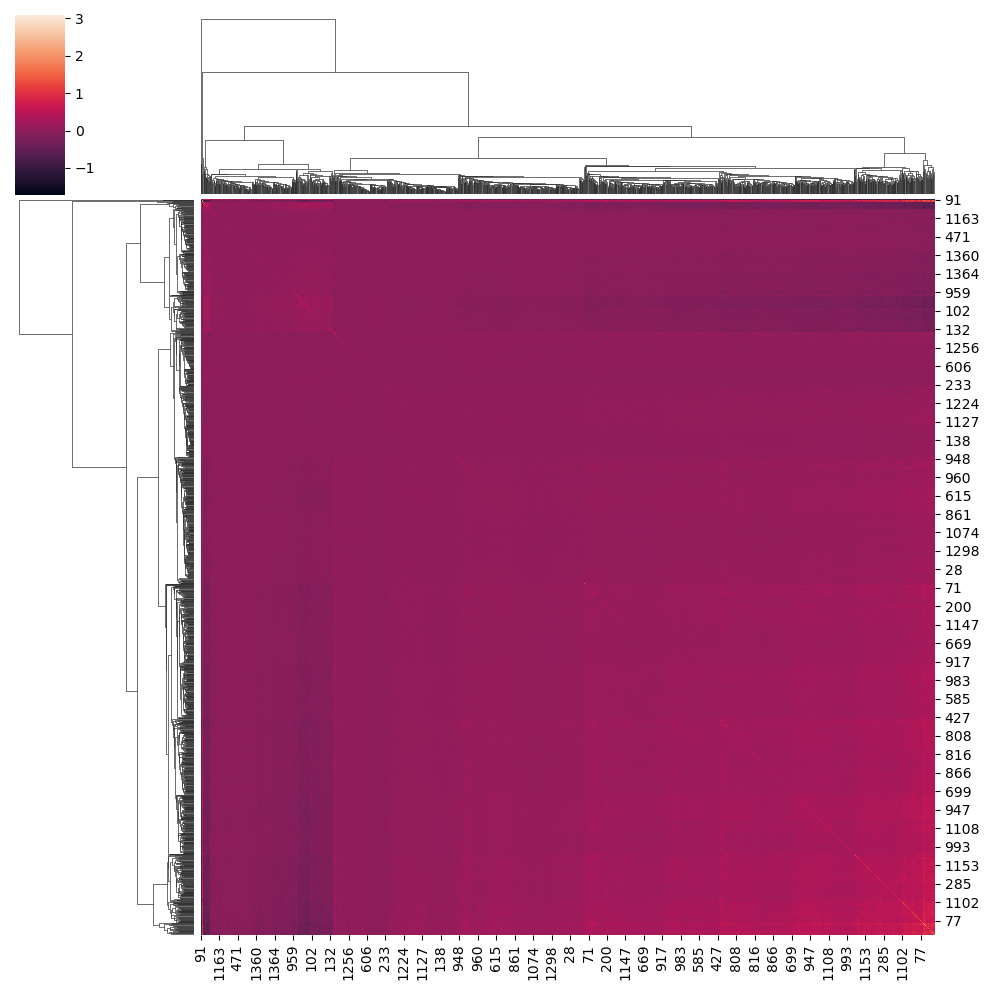

In [30]:
sns.clustermap(transcript_sim_network)

In [31]:
# Creation of a program-to-program similarity based on T and csim

P_network = skn.data.from_edge_list([(tr_tp_st[3][i], tr_tp_st[0][i]) for i in range(len(tr_tp_st[0]))], bipartite=True, sum_duplicates=False)
P = P_network['biadjacency']

In [32]:
P_network

{'names_row': array(['CNN ANDERSON COOPER 360 DEGREES', 'CNN AT THIS HOUR',
        'CNN CNN 10', 'CNN CNN LIVE EVENT/SPECIAL', 'CNN CNN NEWSROOM',
        'CNN CNN RELIABLE SOURCES', 'CNN CNN RIGHT NOW',
        'CNN CNN Special Reports', 'CNN CNN Tonight',
        'CNN CUOMO PRIME TIME', 'CNN EARLY START',
        'CNN ERIN BURNETT OUTFRONT', 'CNN FAREED ZAKARIA GPS',
        'CNN Inside Politics', 'CNN New Day', 'CNN New Day Saturday',
        'CNN New Day Sunday', 'CNN S.E. CUPP UNFILTERED',
        'CNN STATE OF THE UNION', 'CNN Smerconish',
        'CNN THE SITUATION ROOM', 'CNN The Lead with Jake Tapper',
        'Fox News Network FOX AND FRIENDS', 'Fox News Network FOX HANNITY',
        'Fox News Network FOX NEWS @ NIGHT',
        'Fox News Network FOX NEWS SUNDAY',
        'Fox News Network FOX SPECIAL REPORT WITH BRET BAIER',
        'Fox News Network INGRAHAM ANGLE',
        'Fox News Network JUSTICE WITH JUDGE PIRRO',
        'Fox News Network LIFE LIBERTY LEVIN',
        '

In [33]:
program_sim_network = P * transcript_sim_network * P.T

In [34]:
program_sim_network.shape

(51, 51)

In [35]:
pos_program_sim_network = program_sim_network.copy()
pos_program_sim_network[pos_program_sim_network <0] = 0

neg_program_sim_network = program_sim_network.copy()
neg_program_sim_network[neg_program_sim_network >0] = 0

In [36]:
pos_program_sim_network.max()

5030.582827610871

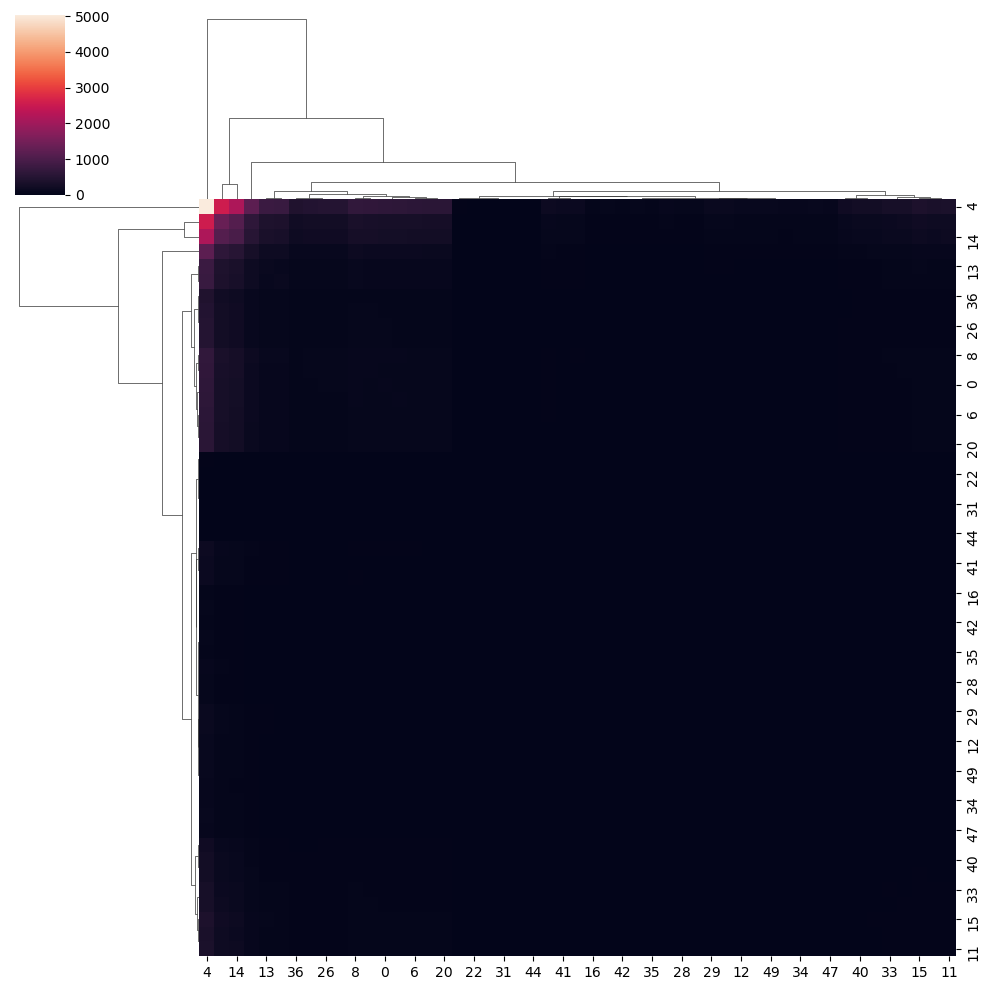

In [37]:
sns.clustermap(pos_program_sim_network)

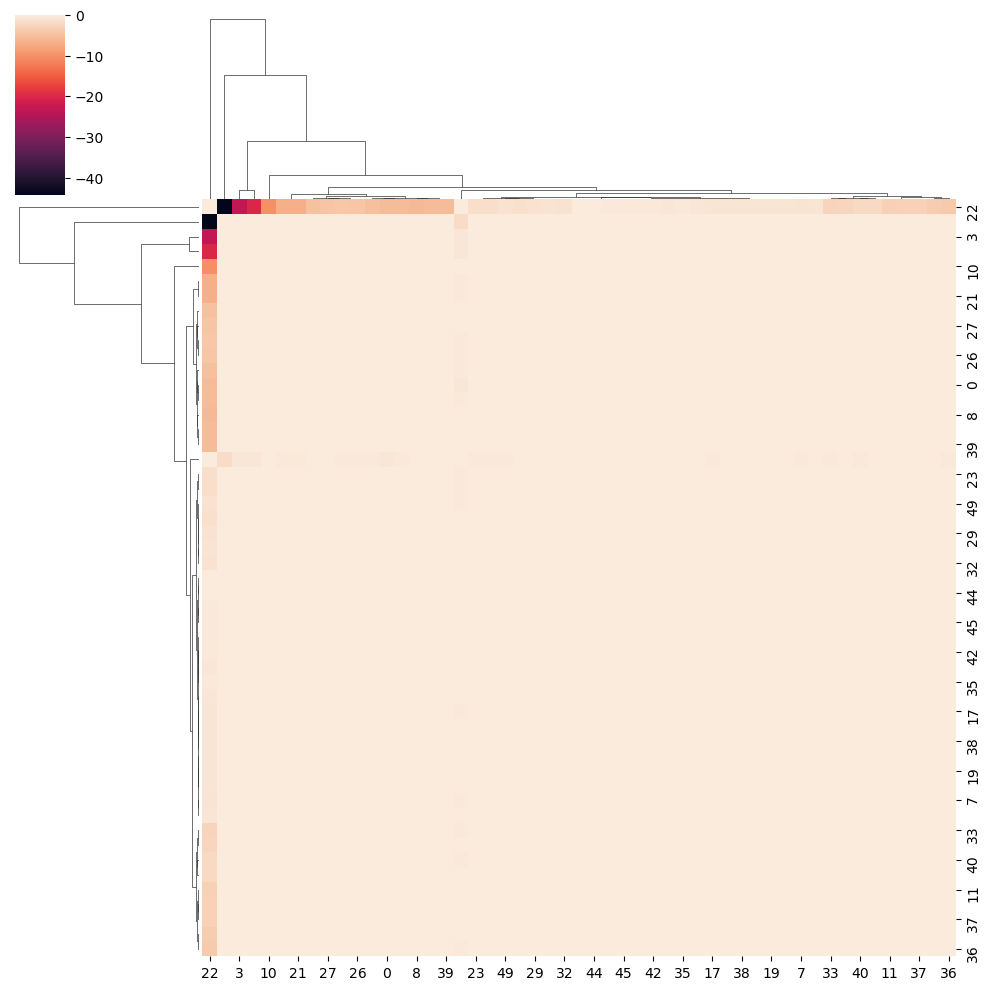

In [38]:
sns.clustermap(neg_program_sim_network)

In [39]:
network_embedding = SpectralEmbedding(affinity='precomputed')
pos_program_embeddings = network_embedding.fit_transform(pos_program_sim_network/pos_program_sim_network.max())
neg_program_embeddings = network_embedding.fit_transform(neg_program_sim_network/neg_program_sim_network.min())

In [40]:
program_df = pd.DataFrame()
program_df['program'] = P_network['names_row']
program_df['network'] = program_df['program'].apply(lambda x: x.split()[0])
program_df['x_pos'] = pos_program_embeddings[:,0]
program_df['y_pos'] = pos_program_embeddings[:,1]
program_df['x_neg'] = neg_program_embeddings[:,0]
program_df['y_neg'] = neg_program_embeddings[:,1]

<Axes: xlabel='x_pos', ylabel='y_pos'>

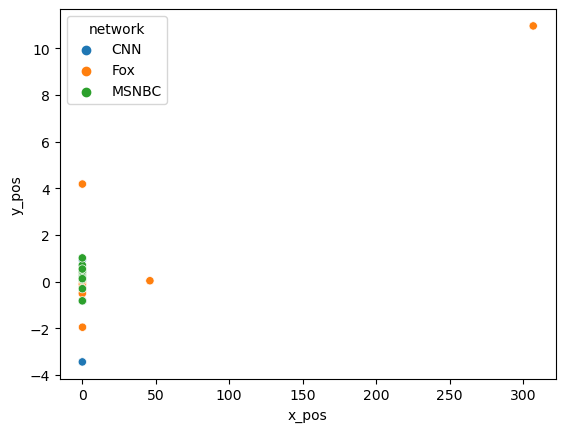

In [41]:
sns.scatterplot(data=program_df, x='x_pos', y='y_pos', hue='network')

<Axes: xlabel='x_neg', ylabel='y_neg'>

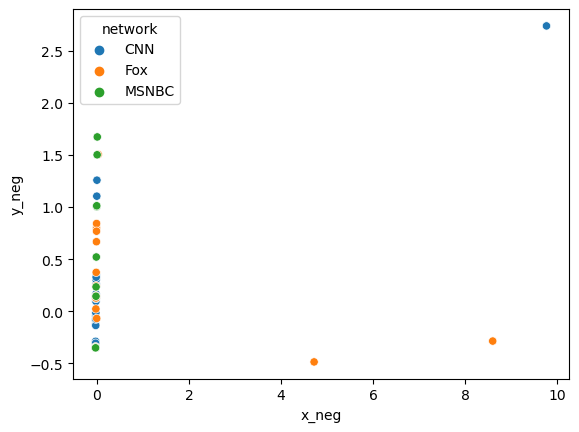

In [42]:
sns.scatterplot(data=program_df, x='x_neg', y='y_neg', hue='network')

## getting differences

In [ ]:
diff = [2 - abs(i - j) for (i, j) in combinations(tr_tp_st[2], 2)]

In [ ]:
diff = [2 - abs(i - j) for (i, j) in combinations(tr_tp_st[2], 2)]
m = np.mean(diff)
std = np.std(diff)
#print(std)
#print(m)
#diff = [(2 - abs(i - j) - m) / std for (i, j) in combinations(tr_tp_st[2], 2)]
diff_matrix = squareform(diff)
print(len(diff_matrix))

In [ ]:
sim_sent = np.multiply(csim, diff_matrix)
print(csim[0][500:550])
print(diff_matrix[0][500:550])
sim_sent[0][500:550]

## Aggregating

In [ ]:
# turning transcript-topics into a dataframe and adding an id var
tdf = pd.DataFrame(
    zip(tr_tp_st[0], tr_tp_st[1], tr_tp_st[2], tr_tp_st[3]),
    columns=["Transcript", "Topic", "Sentiment", "Program"],
)
id = []
for i in range(len(tr_tp_st[0])):
    try:
        id.append(str(tr_tp_st[0][i]) + tr_tp_st[1][i][0])
    except:
        print("oops " + str(tr_tp_st[0][i]))
        id.append(str(tr_tp_st[0][i]))
tdf["id"] = id

### By transcript (Not primarily used)

In [ ]:
prog_list = tdf['Transcript'].unique()
tprogs = tdf['Transcript']
P = []
for i in range(len(prog_list)):
    p = prog_list[i]
    r = [1 if p == t else 0 for t in tprogs]
    P.append(r)
P = np.array(P, dtype='float64')
print(P.shape)
print(P[0])


#colors just a list of program channels for use in graphs
colors = []
t = 0
print(len(tdf['Transcript'].unique()))
for i in range(len(tdf['Program'])):
    p = tdf['Program'][i]
    j = tdf['Transcript'][i]
    if j != t:
        t = j
        if 'CNN' in p:
            colors.append(0)
        elif 'MSNBC' in p:
            colors.append(-1)
        elif 'Fox' in p:
            colors.append(1)
        else:
            print('ah')
print(len(colors))
P[0][1120:1130]

### By Program (What I ended up using)

In [ ]:
prog_list = tdf['Program'].unique()
tprogs = tdf['Program']
P = []
for i in range(len(prog_list)):
    p = prog_list[i]
    r = [1 if p == t else 0 for t in tprogs]
    P.append(r)
P = np.array(P, dtype='float64')
print(P.shape)
print(P[0])

#colors just a list of program channels for use in graphs
colors = []
for p in prog_list:
    if 'CNN' in p:
        colors.append(0)
    elif 'MSNBC' in p:
        colors.append(-1)
    elif 'Fox' in p:
        colors.append(1)
    else:
        print('ah')


Making differences x program matrix (P * S * P^T, S = topic sentiment difference scores * topic simmilarity score)

In [ ]:
M = np.matmul(np.matmul(P,sim_sent),P.T)
print(M.shape)
M[0][1120:1130]

Makind topic simmilarity x program matrix (P * S * P^T, S = simmilarity score between topics)

In [ ]:
M1 = np.matmul(np.matmul(P,csim),P.T)
M1[0][0:50]
M1[0][1120:1130]

Element-wise multiply M time M1 ^ -1 to get average sentiment difference => sum(weighted sent difference) / sum(topic similarity)

In [ ]:
M2 = np.multiply(M, np.power(M1, -1))
M2.shape
np.argwhere(np.isnan(M2))
M2[np.isnan(M2)] = 0

In [ ]:
print(len(np.argwhere(np.isnan(M2))))
M2.size

## Plotting programs (M2) with a bunch of manifold learning methods
### Plot color is program channel
Plot code pulled from here: https://scikit-learn.org/stable/auto_examples/manifold/plot_manifold_sphere.html#sphx-glr-auto-examples-manifold-plot-manifold-sphere-py

In [ ]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from sklearn import manifold
from sklearn.utils import check_random_state

# Unused but required import for doing 3d projections with matplotlib < 3.2
import mpl_toolkits.mplot3d  # noqa: F401

# Variables for manifold learning.
n_neighbors = 6
n_samples = 51

# Plot our dataset.
fig = plt.figure(figsize=(15, 8))
plt.suptitle(
    "Manifold Learning with %i points, %i neighbors" % (51, n_neighbors), fontsize=14
)

#colors = colors[:1340]

sphere_data = M2

# Perform Locally Linear Embedding Manifold learning
methods = ["standard", "ltsa", "hessian", "modified"]
labels = ["LLE", "LTSA", "Hessian LLE", "Modified LLE"]

for i, method in enumerate(methods):
    t0 = time()
    trans_data = (
        manifold.LocallyLinearEmbedding(
            n_neighbors=n_neighbors, n_components=2, method=method
        )
        .fit_transform(sphere_data)
        .T
    )
    t1 = time()
    print("%s: %.2g sec" % (methods[i], t1 - t0))

    ax = fig.add_subplot(252 + i)
    plt.scatter(trans_data[0], trans_data[1], c=colors, cmap=plt.cm.rainbow)
    plt.title("%s (%.2g sec)" % (labels[i], t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis("tight")

# Perform Isomap Manifold learning.
t0 = time()
trans_data = (
    manifold.Isomap(n_neighbors=n_neighbors, n_components=2)
    .fit_transform(sphere_data)
    .T
)
t1 = time()
print("%s: %.2g sec" % ("ISO", t1 - t0))

ax = fig.add_subplot(257)
plt.scatter(trans_data[0], trans_data[1], c=colors, cmap=plt.cm.rainbow)
plt.title("%s (%.2g sec)" % ("Isomap", t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis("tight")

# Perform Multi-dimensional scaling.
t0 = time()
mds = manifold.MDS(2, max_iter=100, n_init=1, normalized_stress="auto")
trans_data = mds.fit_transform(sphere_data).T
t1 = time()
print("MDS: %.2g sec" % (t1 - t0))

ax = fig.add_subplot(258)
plt.scatter(trans_data[0], trans_data[1], c=colors, cmap=plt.cm.rainbow)
plt.title("MDS (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis("tight")

# Perform Spectral Embedding.
t0 = time()
se = manifold.SpectralEmbedding(n_components=2, n_neighbors=n_neighbors)
trans_data = se.fit_transform(sphere_data).T
t1 = time()
print("Spectral Embedding: %.2g sec" % (t1 - t0))

ax = fig.add_subplot(259)
plt.scatter(trans_data[0], trans_data[1], c=colors, cmap=plt.cm.rainbow)
plt.title("Spectral Embedding (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis("tight")

# Perform t-distributed stochastic neighbor embedding.
t0 = time()
tsne = manifold.TSNE(n_components=2, random_state=0)
trans_data = tsne.fit_transform(sphere_data).T
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))

ax = fig.add_subplot(2, 5, 10)
plt.scatter(trans_data[0], trans_data[1], c=colors, cmap=plt.cm.rainbow)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis("tight")

plt.show()